In [2]:
import numpy as np
import pandas as pd

import xarray as xr
from aqmsp_data.preprocessing import preprocess_camx_pm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
kilns_path = ""

In [4]:
# create a timeseries for nov and dec of 2023.
# like: 20231101, 20231102, ..., 20231130, 20231201, ..., 20231231

dates = pd.date_range(start="2023-11-01", end="2023-12-25", freq="D")

ds_list = []
for date in tqdm(dates):
    date_str = date.strftime("%Y%m%d")
    ds = xr.open_dataset(f"/home/patel_zeel/sarath_auto_download/data/camxout.pmsa.{date_str}.nc")
    ds = preprocess_camx_pm(ds)
    ds_list.append(ds)

  0%|          | 0/55 [00:00<?, ?it/s]

In [5]:
master_ds = xr.concat(ds_list, dim="time")
master_ds

<xarray.Dataset> Size: 811MB
Dimensions:    (time: 1320, latitude: 80, longitude: 80)
Coordinates:
  * latitude   (latitude) float64 640B 28.2 28.21 28.22 ... 28.97 28.98 28.99
  * longitude  (longitude) float64 640B 76.85 76.86 76.87 ... 77.62 77.63 77.64
  * time       (time) datetime64[ns] 11kB 2023-11-01T05:30:00 ... 2023-12-26T...
Data variables: (12/24)
    P10_00     (time, latitude, longitude) float32 34MB 55.22 55.22 ... 41.84
    P25_00     (time, latitude, longitude) float32 34MB 44.11 44.11 ... 40.76
    P10_01     (time, latitude, longitude) float32 34MB 53.4 53.4 ... 41.84
    P25_01     (time, latitude, longitude) float32 34MB 42.3 42.3 ... 40.76
    P10_02     (time, latitude, longitude) float32 34MB 53.39 53.39 ... 41.26
    P25_02     (time, latitude, longitude) float32 34MB 42.29 42.29 ... 40.18
    ...         ...
    P10_09     (time, latitude, longitude) float32 34MB 55.22 55.22 ... 41.84
    P25_09     (time, latitude, longitude) float32 34MB 44.11 44.11 ... 40.76
    P10_10     (time, latitude, longitude) float32 34MB 55.22 55.22 ... 41.84
    P25_10     (time, latitude, longitude) float32 34MB 44.1 44.1 ... 40.76
    P10_11     (time, latitude, longitude) float32 34MB 55.22 55.22 ... 41.84
    P25_11     (time, latitude, longitude) float32 34MB 44.11 44.11 ... 40.76
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023305
    CTIME:          85518
    WDATE:          2023305
    ...             ...
    VGLVLS:         [0. 0.]
    GDNAM:          ????????????????
    UPNAM:          CAMXMETOU       
    VAR-LIST:       P10_${SCEN}         P25_${SCEN}         
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:

In [6]:
p0 = master_ds["P25_00"].mean(dim=["latitude", "longitude"])
p_bk = (master_ds["P25_00"].mean(dim=["latitude", "longitude"]) - master_ds["P25_07"].mean(dim=["latitude", "longitude"]))
# print("Min", diff.min().values)
# print("Max", diff.max().values)
# diff.plot()
p_bk.sum() / p0.sum() * 100

<xarray.DataArray ()> Size: 8B
array(8.36633295)

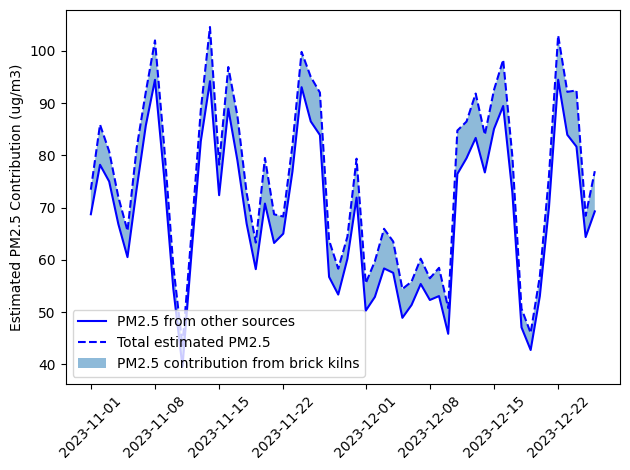

In [7]:
p_bk_daily = p_bk.resample(time="D").mean()
p_0_daily = p0.resample(time="D").mean()

plt.plot(p_bk_daily.time, p_0_daily - p_bk_daily, label="PM2.5 from other sources", c='b')
plt.plot(p_0_daily.time, p_0_daily, label="Total estimated PM2.5", c='b', linestyle='--')
plt.fill_between(p_bk_daily.time, p_0_daily - p_bk_daily, p_0_daily, alpha=0.5, label="PM2.5 contribution from brick kilns")
plt.legend()
plt.ylabel("Estimated PM2.5 Contribution (ug/m3)")
# rotate x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("/home/patel_zeel/kdd24_brick_kilns/images/kdd24_pm25_brick_kiln_contribution.png", dpi=300)

## Correlation

In [8]:
import geopandas as gpd
delhi = gpd.read_file("/home/patel_zeel/aqmsp/aqmsp_data/datasets/shapefiles/delhi/Districts.shp")

In [9]:
kilns_path = "/home/rishabh.mondal/Brick-Kilns-project/albk/experiments/data_preperation/metadata_new (1).csv"
kiln_csv = pd.read_csv(kilns_path)
kiln_csv.head(2)

ImageName   Latitude  Longitude
0  kiln_1.png  28.399170  77.631222
1  kiln_2.png  28.411609  77.619730

In [20]:
kiln_ds = master_ds['P25_00'] - master_ds['P25_07']

for i in tqdm(range(0, 120)):
    fig, ax = plt.subplots()
    kiln_ds.clip(min=0).isel(time=i).plot(ax=ax, cmap='coolwarm', vmin=0, vmax=100, alpha=0.8, label="PM2.5 (ug/m3)")
    ax.scatter(kiln_csv['Longitude'], kiln_csv['Latitude'], c='r', s=1, label="Brick Kilns")
    delhi.plot(ax=ax, color="none", edgecolor='black')
    
    # add label to the colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_label("PM2.5 (ug/m3)")
    plt.legend(loc='lower left')
    fig.savefig(f"/tmp/del_anim/{str(i).zfill(4)}.png")
    plt.close()
    # break

  0%|          | 0/120 [00:00<?, ?it/s]

/tmp/ipykernel_238190/1260533516.py:12: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left')
/tmp/ipykernel_238190/1260533516.py:12: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left')
/tmp/ipykernel_238190/1260533516.py:12: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left')
/tmp/ipykernel_238190/1260533516.py:12: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='l

In [21]:
# create gif
!convert -delay 20 -loop 0 /tmp/del_anim/*.png /tmp/del_anim/delhi_kilns.gif

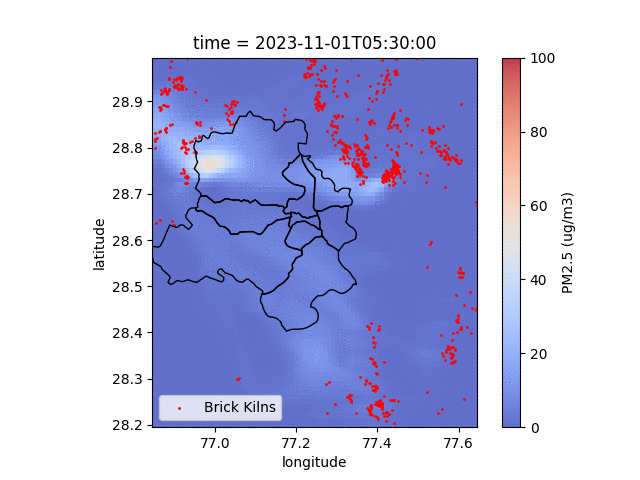

In [22]:
# show gif
from IPython.display import Image

Image(filename='/tmp/del_anim/delhi_kilns.gif')